# Example for the Audio Encoder model

This notebook illustrates the core power of `encoder networks` : the ability to generalize to unseen labels !

Here is the general principle : 
1. Split the `common_voice` + `voxforge` datasets (or `LibriSpeech`) in 2 subsets, where **all** speakers are different (i.e. no speaker from valid set is in the train set and vice-versa)
2. Create grouper dataset format for both : this kind of dataset creates *groups* of `n_utterance` data belonging to the same speake (i.e. if `n_utterance = 4`, `generator[0:4]` are from speaker 1, `generator[4:8]` from speaker 2 etc.).
3. Preload a large amount of audios : grouper datasets work with random groups so the same audio may appear in multiple groups. To avoid reloading multiple times the same data, we cache them ! It is the reason why I am using an `AudioGrouperGenerator` as dataset (it also works without but it is much slower). Note that this operation is memory-intensive so make sure to adapt `cache_size` according to your **CPU** memory (50k is a good choice for 32Go RAM). 
4. Train the model on the `train_set` and evaluate it on `valid_set`. Reminder : **all** validation metrics will be on **new labels**
5. Make funny plots !

Performance note : when caching 100% of the dataset, I achieve less than 400ms/batch performance while a 2s/batch when loading a smaller part and far more if not using the generator.

*Raw Audio* vs *Mel spectrogram* input : both are performant (maybe raw audio is slighly better) but it seems that `mel-based` models are better to usefor the `SV2TTS` architecture (cf https://github.com/yui-mhcp/text_to_speech project). 

Note : this notebook is an adapted copy of `example_audio_siamese` so it is possible that some parts have not been fully adapted ;) Furthermore, some features available in `siamese networks` are not implemented in the `encoder networks` yet but will be in the next update !

## Imports + model initialization

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from utils import *
from loggers import *
from models import get_pretrained
from models.siamese import AudioEncoder
from custom_train_objects import AudioGrouperGenerator
from datasets import get_dataset, prepare_dataset, train_test_split, test_dataset_time, get_dataset_dir

set_display_options()

model_name = 'audio_encoder_256_mel_lstm_2'

print("Tensorflow version : {}".format(tf.__version__))
print('Available GPU(s) : {}'.format(tf.config.list_physical_devices('GPU')))

Tensorflow version : 2.10.0
Available GPU(s) : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Model creation

In [2]:
embedding_dim = int(model_name.split('_')[2])
input_type    = model_name.split('_')[3]
flatten_type  = model_name.split('_')[4]

config = {
    'distance_metric' : 'euclidian',
    'input_type'    : input_type,
    'audio_rate'    : 22050,
    'use_fixed_length_input' : False,
    'embedding_dim' : embedding_dim,

    'normalize'        : True,
    'max_audio_time'   : 3,
    'flatten_type'     : flatten_type,
    'final_activation' : 'relu'
}

model = AudioEncoder(nom = model_name, ** config)

print(model)
#model.encoder.summary()

Set `use_mask = True` by default as the masking operation is supported. To remove this message or change the behavior, explicitely pass `use_mask = ...`
Initializing model with kwargs : {'model': <keras.engine.sequential.Sequential object at 0x7f560478bc40>}
Initializing submodel : `model` !
Submodel model saved in pretrained_models/audio_encoder_256_mel_lstm_2/saving/model.json !
Model audio_encoder_256_mel_lstm_2 initialized successfully !

========== audio_encoder_256_mel_lstm_2 ==========
Sub model model
- Inputs 	: (None, None, 80)
- Outputs 	: (None, 256)
- Number of layers 	: 28
- Number of parameters 	: 2.669 Millions
- Model not compiled

Already trained on 0 epochs (0 steps)

- Embedding dim : 256
- Distance metric : euclidian
- Audio rate : 22050
- # mel channels : 80



**Important note** : in the below cell (the model summary), you can observe some custom layers *Masked...*. These layers are subclasses of their associated layer, but with masking support, meaning that if some parts of the input sequence is masked by the `Masking` layer, they will use and propagate the mask (which is currently not supported in regular `Conv1D`).

The `MaskedZeroPadding1D` is there to make a `padding = 'same'` behavior in a *manual* way (you can disable it by setting the config `use_manual_padding = False`). I have noticed that, `padding = 'same'` in `Conv1D` does not give the same result as if you manually zero-pads the input which differs from the `torch` behavior (and thus can cause issue when converting models). Furthermore, when `batch_size > 1`, the padding is not put at the same place as if no batching was applied (and then no data-padding) (which is consitant with the way padding works) but it therefore gives different results with and without batching. The `MaskedZeroPadding1D` solves this issue and now you can batch your sequential data without any issue ! :)

If you want more information about this phenomenon and the way I solved it, you can contact me or read the code ;)

In [3]:
model.summary()


========== Summary of model ==========

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, None, 80)          0         
                                                                 
 masked_zero_padding1d (Mask  (None, None, 80)         0         
 edZeroPadding1D)                                                
                                                                 
 conv_1 (MaskedConv1D)       (None, None, 128)         71808     
                                                                 
 batch_normalization (BatchN  (None, None, 128)        512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, None, 128)         0         
                                                                 
 dropout (Dropout)

## Model instanciation + dataset loading

In [4]:
model = get_pretrained(model_name)

lr = {'name' : 'DivideByStep', 'maxval' : 1e-3, 'minval' : 1e-4}

model.compile(
    optimizer   = 'rmsprop', 
    loss_config = {'init_w' : 1 if model.distance_metric in ('dp', 'cosine') else -1},
    optimizer_config = {'lr' : lr}
)
print(model)

Model model is already compiled !

========== audio_encoder_256_mel_lstm_2 ==========
Sub model model
- Inputs 	: (None, None, 80)
- Outputs 	: (None, 256)
- Number of layers 	: 28
- Number of parameters 	: 2.669 Millions
- Optimizer 	: {'name': 'RMSprop', 'learning_rate': {'class_name': 'DivideByStep', 'config': {'factor': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, 'minval': <tf.Tensor: shape=(), dtype=float32, numpy=1e-04>, 'maxval': <tf.Tensor: shape=(), dtype=float32, numpy=0.001>}}, 'decay': 0.0, 'rho': 0.8999999761581421, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}
- Loss 	 : {'reduction': 'none', 'name': 'ge2e_loss', 'mode': 'softmax', 'init_w': -9.9265175, 'init_b': 0.14750148, 'distance_metric': 'euclidian'}
- Metrics	 : [{'name': 'ge2e_metric', 'dtype': 'float32', 'mode': 'softmax', 'distance_metric': 'euclidian'}]

Already trained on 25 epochs (63201 steps)

- Embedding dim   : 256
- Distance metric : euclidian
- Audio rate : 22050
- # mel channels : 80



In [ ]:
preload     = True
n_utterance = 32
datasets    = ['common_voice', 'voxforge']
batch_size  = n_utterance ** 2 

dataset     = get_dataset(datasets)
if isinstance(dataset, dict):
    train, valid = dataset['train'], dataset['valid']
else:
    train, valid = train_test_split(dataset, valid_size = 0.1, split_by_unique = True, min_occurence = n_utterance)

train = sample_df(train, n = None, n_sample = 2500, random_state = 10)
valid = sample_df(valid, n = None, n_sample = 2500, random_state = 10)

train = AudioGrouperGenerator(
    train, n_utterance = n_utterance, rate = model.audio_rate, mel_fn = model.mel_fn,
    batch_size = batch_size, n_round = 25, cache_size = 50000, min_occurence = 0, preload = preload, random_state = 10, shuffle = True
)
valid = AudioGrouperGenerator(
    valid, n_utterance = n_utterance, rate = model.audio_rate, mel_fn = model.mel_fn,
    batch_size = batch_size, n_round = 5, cache_size = 0, min_occurence = 0, preload = preload, shuffle = False
)

print("Dataset length :\n  Training set : {}\n  Validation set : {}".format(
    len(train), len(valid)
))

In [6]:
print('{}\n\n{}\n'.format(train, valid))

print("Number of ids in valid also in train : {}".format(
    sum([valid_id in train.ids for valid_id in valid.ids])
))
print("Number of ids in train also in train (to test) : {}".format(
    sum([train_id in train.ids for train_id in train.ids])
))

AudioGrouper Generator :
- Length : 805344
- Unique ids   : 1797
- Total files  : 805344
- Unique files : 253220 (31.44 %)
- Cache size   : 50000 (loaded : 100.00 %)

AudioGrouper Generator :
- Length : 32000
- Unique ids   : 200
- Total files  : 32000
- Unique files : 6929 (21.65 %)
- Cache size   : 0 (loaded : 0.00 %)

Number of ids in valid also in train : 0
Number of ids in train also in train (to test) : 1797


## Training

Note that `cache = False` and `shuffle_size = 0` are recommanded to not waste memory / time as the `generator` already cache the right amount of file (to not overload your memory) and shuffle the whole dataset at every epoch. 

The `GE2EMetric` is a custom metric created based on the `GE2ELoss` : the loss uses either `categorical_crossentropy (mode = 'softmax')` either `binary_crossentropy (mode = 'contrast')` so I simply use the associated metric (`categorical_accuracy` or `EER`) to compute metrics.

In [8]:
print("Training samples   : {} - {} batches".format(len(train), len(train) // batch_size))
print("Validation samples : {} - {} batches".format(len(valid), len(valid) // (batch_size * 2)))

for epochs in [4]:
    hist = model.train(
        train, validation_data = valid, pred_step = -50,
        epochs = epochs, batch_size = train.batch_size, valid_batch_size = valid.batch_size,
        cache = False, shuffle_size = 0, augment_prct = 0.25
    )

Training samples   : 805344 - 786 batches
Validation samples : 32000 - 15 batches
Training config :
HParams :
- augment_prct	: 0.25
- trim_audio	: False
- reduce_noise	: False
- trim_threshold	: 0.1
- max_silence	: 0.15
- trim_method	: window
- trim_mode	: start_end
- trim_mel	: False
- trim_factor	: 0.6
- trim_mel_method	: max_start_end
- batch_size	: 1024
- train_batch_size	: None
- valid_batch_size	: 1024
- test_batch_size	: 1
- shuffle_size	: 0
- epochs	: 4
- verbose	: 1
- train_times	: 1
- valid_times	: 1
- train_size	: None
- valid_size	: None
- test_size	: 4
- pred_step	: -50

Running on 1 GPU

Epoch 22 / 25
Epoch 22/4
780/780 [==============================] - 2171s 3s/step - loss: 0.0505 - ge2e_metric: 0.9917 - val_loss: 0.0371 - val_ge2e_metric: 0.9956

Saving at epoch 22 !

Epoch 23 / 25
Epoch 23/4
780/780 [==============================] - 2022s 3s/step - loss: 0.0460 - ge2e_metric: 0.9926 - val_loss: 0.0382 - val_ge2e_metric: 0.9957

Epoch 24 / 25
Epoch 24/4
675/780 [=====

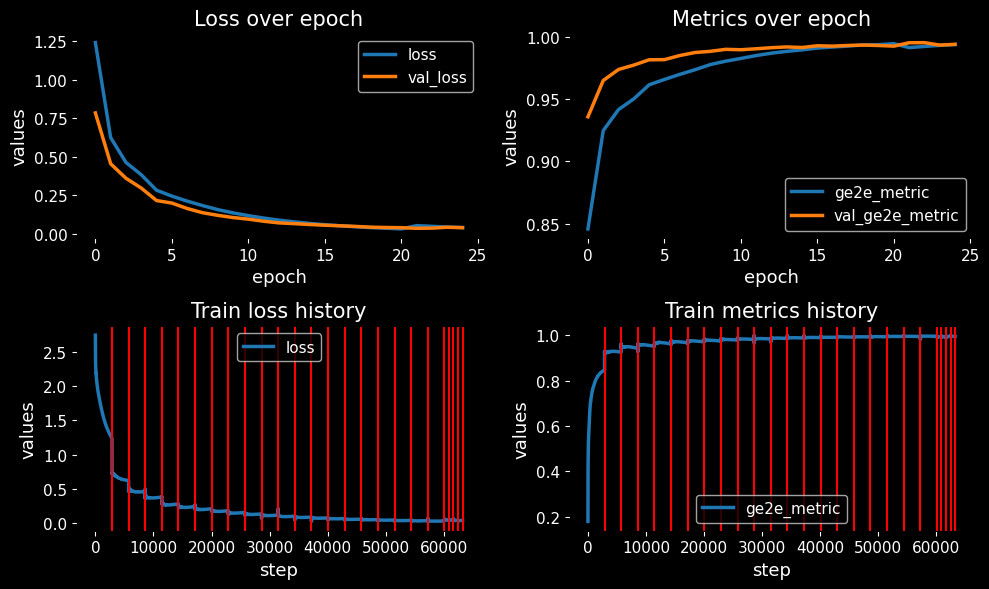

===== History =====
        loss  ge2e_metric  val_loss  val_ge2e_metric
0   1.240474     0.845672  0.784769         0.935955
1   0.624663     0.924804  0.455191         0.965194
2   0.463993     0.941787  0.361364         0.974066
3   0.384228     0.950401  0.297708         0.977586
4   0.283815     0.961721  0.216996         0.981861
5   0.245777     0.966025  0.200683         0.981968
6   0.213285     0.970080  0.165493         0.985273
7   0.184478     0.973844  0.138320         0.987716
8   0.158409     0.978010  0.121219         0.988649
9   0.137079     0.980725  0.106795         0.990266
10  0.119259     0.982941  0.096342         0.989943
11  0.103517     0.985269  0.082889         0.990733
12  0.090025     0.987196  0.072239         0.991595
13  0.078835     0.988646  0.067339         0.992205
14  0.068884     0.989840  0.061727         0.991738
15  0.060273     0.991269  0.057148         0.993139
16  0.053591     0.992132  0.053226         0.992852
17  0.047095     0.992923 

In [9]:
model.plot_history()
print(model.history)

## Evaluation

**Reminder** the model was trained on `CommonVoice + VoxForge` French datasets, while beeing evaluated to classify speakers from `LibriSpeech` (English dataset). The 96% classification accuracy perfectly illustrates the generalization ability of Encoders network, to classify new labels, as soon as you give it some examples of it.

In [ ]:
h = model.test(valid)

Loading dataset librispeech...


2023-04-30 14:56:30.743000: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-04-30 14:56:31.325459: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Accuracy : 96.52 %


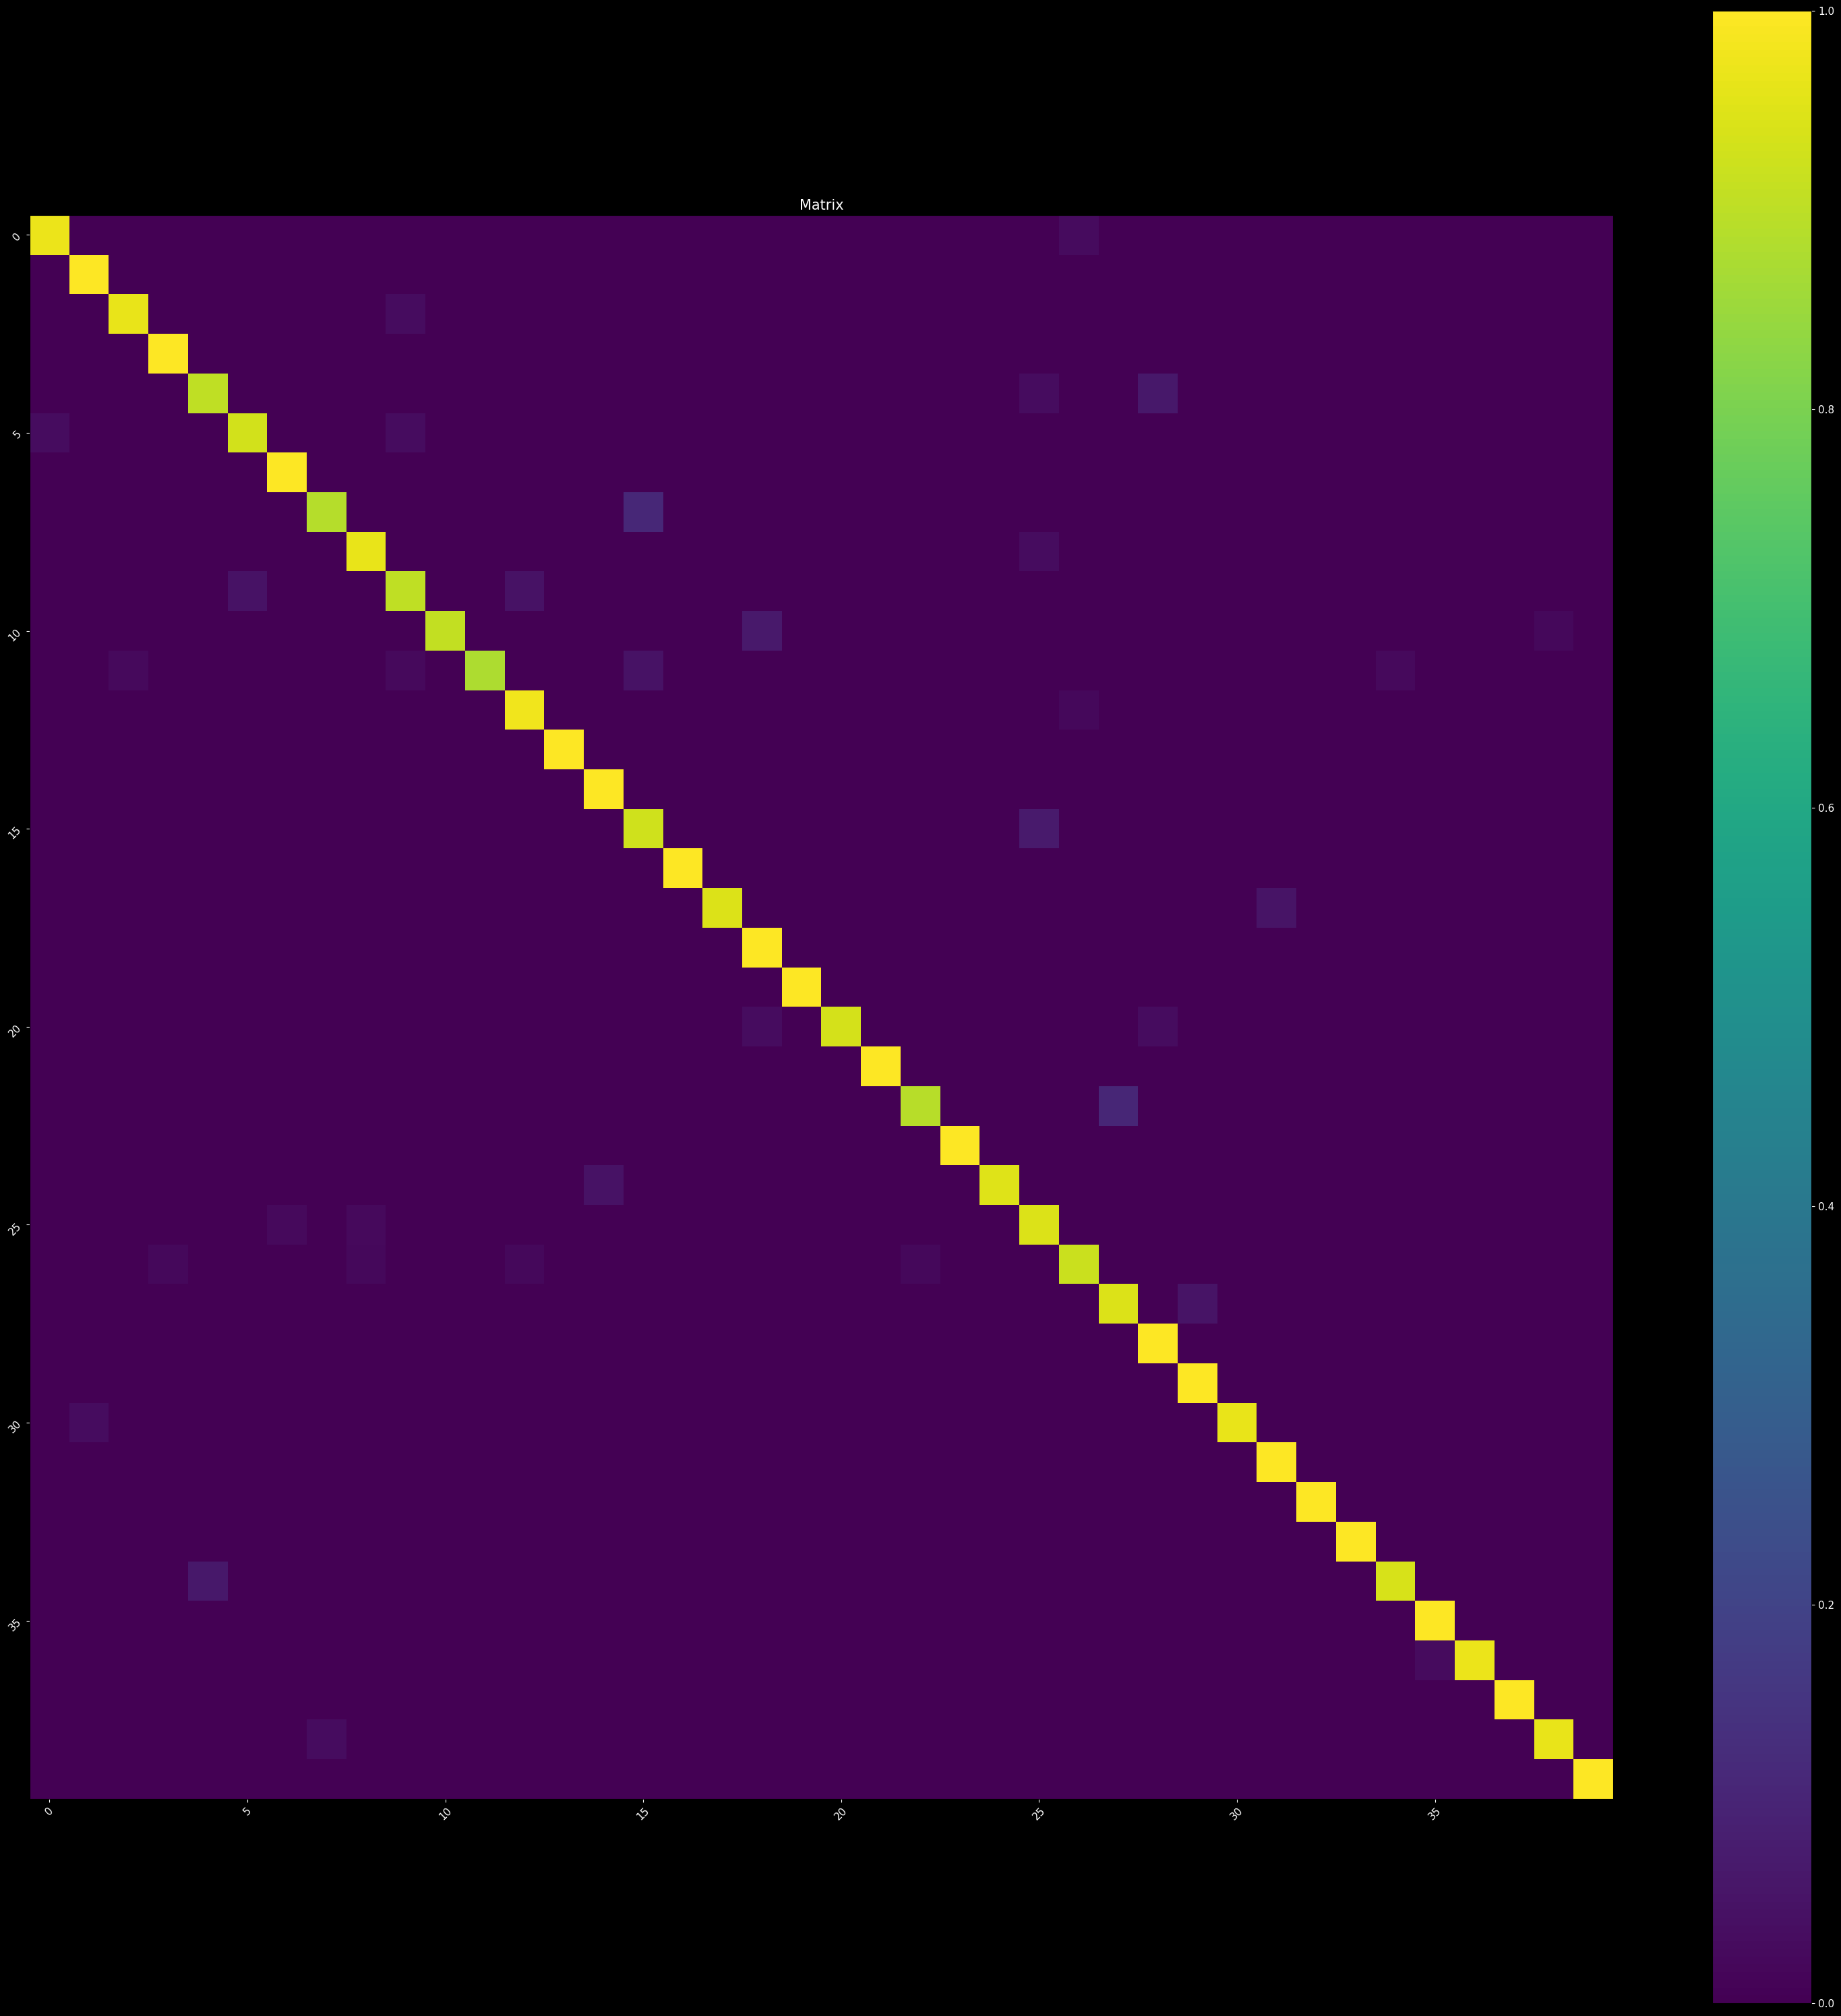

In [3]:
new_ds  = get_dataset('librispeech', modes = 'valid')

samples = sample_df(new_ds, n = None, n_sample = 100, random_state = 0)

queries = sample_df(samples, n = None, n_sample = 0.5, random_state = 0, drop = False)
samples = samples.loc[[idx for idx in samples.index if idx not in queries['index'].values]]

results = model.evaluate(queries, samples = samples)

print('Accuracy : {:.2f} %'.format(results['metrics']['accuracy'] * 100))
plot_matrix(results['confusion_matrix'], norm = True)

## Embedding


### Random samples embeddings

In [ ]:
samples    = pd.DataFrame([valid[i] for i in range(valid.batch_size)])
embeddings = model.embed(samples)

lines = list(range(0, len(embeddings), valid.n_utterance))

plot_matrix(
    model.distance(embeddings, embeddings, as_matrix = True, force_distance = False),
    norm = False, hlines = lines, vlines = lines
)

plot_embedding(embeddings, ids = samples['id'].values, with_legend = False)

embeddings

Loading dataset librispeech...


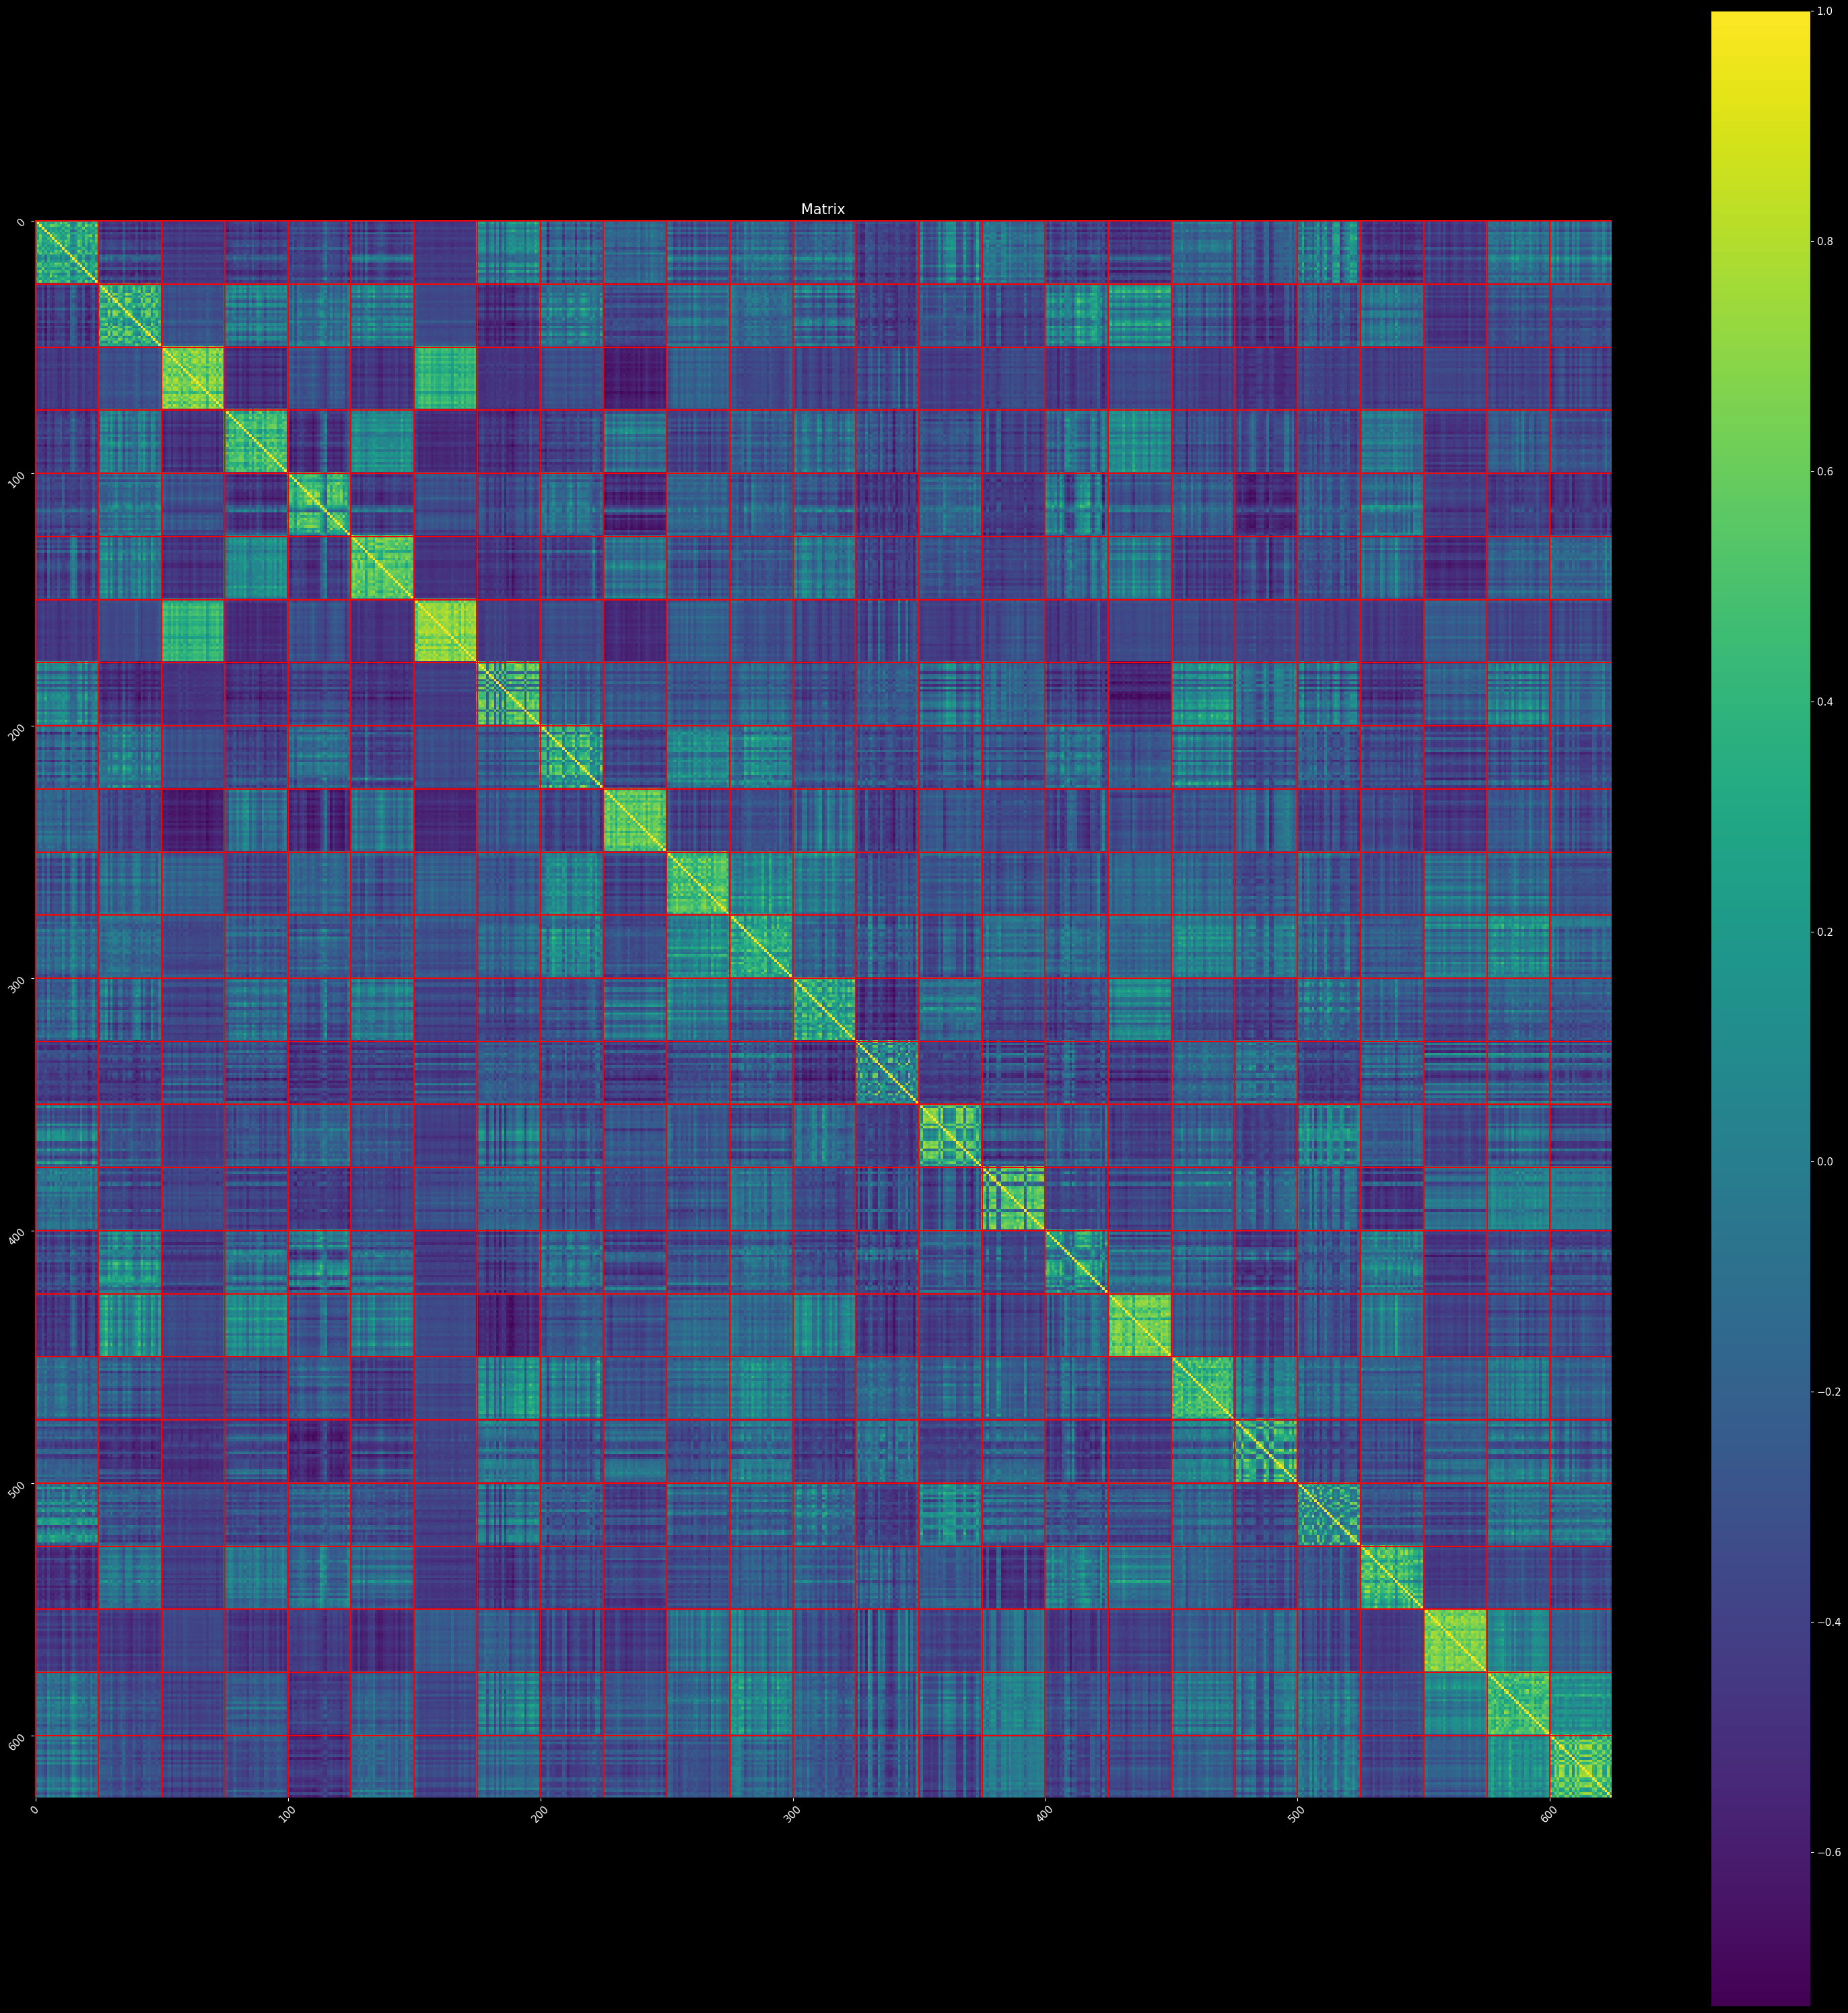

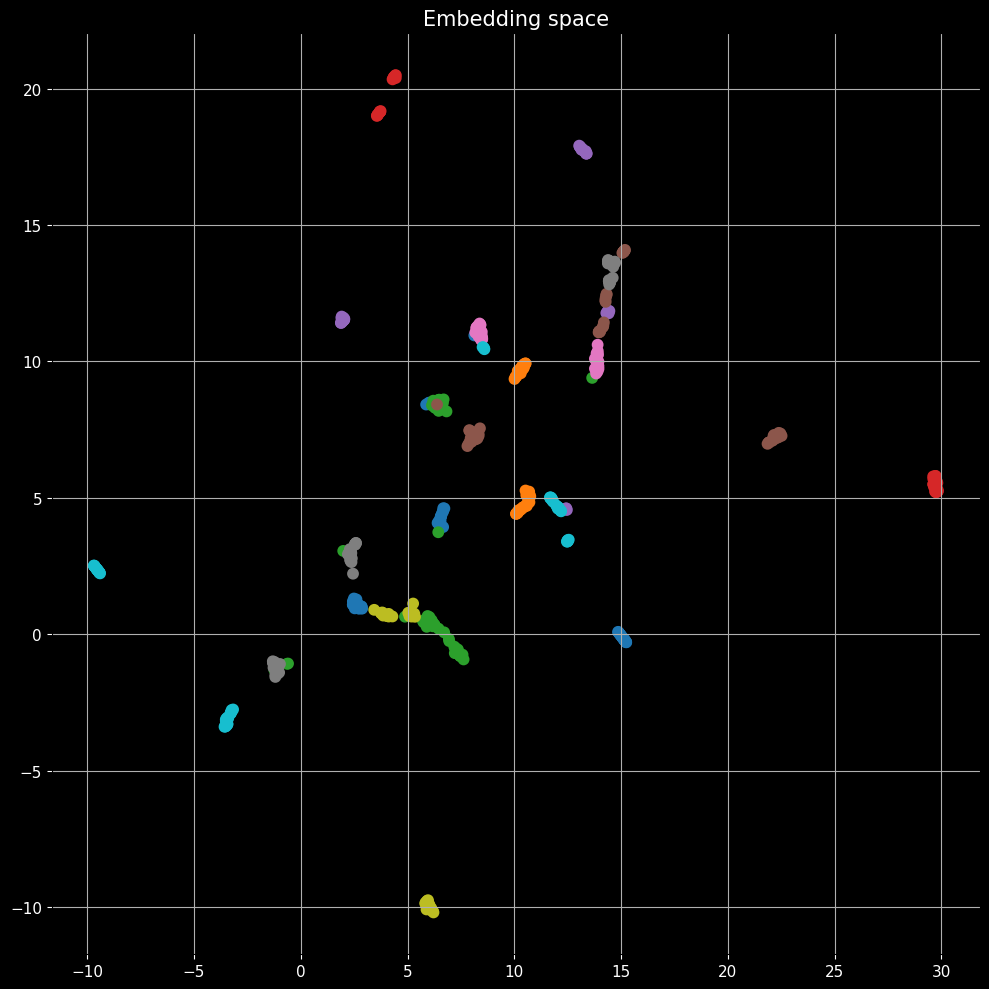

<tf.Tensor: shape=(625, 256), dtype=float32, numpy=
array([[ 1.3984826e-02,  1.5687023e-05, -3.1941238e-06, ...,
         2.4662468e-06, -9.0776586e-05, -1.6181855e-05],
       [-2.0426121e-02,  1.4324129e-05, -3.0526460e-06, ...,
         1.6592892e-06,  3.7128815e-05, -6.8078375e-06],
       [ 6.9515500e-03,  1.3719679e-05, -4.9727637e-06, ...,
         1.1677068e-05, -4.6781042e-05, -1.2948828e-05],
       ...,
       [-1.1880012e-03,  1.8650780e-05, -1.7560081e-06, ...,
        -2.4805288e-06, -3.6576728e-04, -7.1192039e-06],
       [-2.8663094e-03,  2.4998053e-05, -5.1106264e-07, ...,
         2.2636254e-08, -5.7446799e-04, -8.2069782e-06],
       [ 4.2110919e-03,  2.4594441e-05, -2.2492407e-06, ...,
        -1.4321910e-06, -2.0990170e-04, -7.4825934e-06]], dtype=float32)>

In [5]:
new_ds  = get_dataset('librispeech', modes = 'valid')

samples = sample_df(new_ds, n = 25, n_sample = 25)

embeddings = model.embed(samples)

lines  = list(range(0, len(embeddings), len(samples['id'].unique())))
matrix = model.predict_similarity_matrix(embeddings)

plot_matrix(
    matrix, norm = False, hlines = lines, vlines = lines
)

plot_embedding(embeddings, ids = samples['id'].values, with_legend = False)

embeddings

### Dataset embeddings

In [ ]:
model = get_pretrained(model_name)

if not model.use_fixed_length_input: model.max_audio_time = 10.

audio_kwargs = {
    'trim_silence'  : True,
    'reduce_noise'  : True,
    'method'        : 'window',
    'mode'          : 'start_end',
    'threshold' : 0.075,
}

list_ds = [
#    ('mls', '{}/MLS/fr'.format(get_dataset_dir())),
    ('siwis',        '{}/SIWIS/fr'.format(get_dataset_dir())),
    ('voxforge',     '{}/VoxForge'.format(get_dataset_dir())),
    ('common_voice', '{}/CommonVoice'.format(get_dataset_dir()))
]
for name, path in list_ds:
    ak = {} #if name != 'common_voice' else audio_kwargs
    
    ds = get_dataset(name)
    
    if isinstance(ds, dict):
        for mode, ds_mode in ds.items():
            if mode == 'valid': mode = 'test'
            res = model.embed_dataset(
                os.path.join(path, mode), ds_mode, save_every = 25000, cache_size = 10000,
                embedding_name = model.nom
            )
            print(res)
    else:
        res = model.embed_dataset(
            path, ds, save_every = 25000, cache_size = 10000,
            embedding_name = model.nom, tqdm = tqdm
        )
        print(res)
        plot_embedding(sample_df(res, n = 25, n_sample = 20))


In [5]:
model.max_input_length

259

In [13]:
from utils.embeddings import *

emb1 = load_embedding('/storage/SIWIS/fr', embedding_name = model.nom)
emb2 = load_embedding('/storage/SIWIS/fr', embedding_name = model.nom + '_test')

print(is_equal(embeddings_to_np(emb1), embeddings_to_np(emb2)))

(False, 'Values differ (2380847 / 2499328 diff, 0.953%) : max 0.2894447445869446 - mean 0.00613488769158721 - min 9.094947017729282e-13')


## Pre-processing (dataset resampling)

In [1]:
from datasets.custom_datasets import get_dataset_dir, resample_librispeech

path = '{}/LibriSpeech'.format(get_dataset_dir())
resample_librispeech(path, 22050, subset = ['test-clean', 'train-clean-100']) #, 'train-clean-360'])

0it [00:00, ?it/s]

Resampling dataset to 22050
  2620 files already processed
  0 files to process



0it [00:00, ?it/s]

Resampling dataset to 22050
  28539 files already processed
  0 files to process



0it [00:00, ?it/s]

Resampling dataset to 22050
  104014 files already processed
  0 files to process


filename  \
0       D:/datasets/LibriSpeech\train-clean-360\14\208...   
1       D:/datasets/LibriSpeech\train-clean-360\14\208...   
2       D:/datasets/LibriSpeech\train-clean-360\14\208...   
3       D:/datasets/LibriSpeech\train-clean-360\14\208...   
4       D:/datasets/LibriSpeech\train-clean-360\14\208...   
...                                                   ...   
104009  D:/datasets/LibriSpeech\train-clean-360\9026\2...   
104010  D:/datasets/LibriSpeech\train-clean-360\9026\2...   
104011  D:/datasets/LibriSpeech\train-clean-360\9026\2...   
104012  D:/datasets/LibriSpeech\train-clean-360\9026\2...   
104013  D:/datasets/LibriSpeech\train-clean-360\9026\2...   

                                                     text    id  total_time  \
0       Chapter eleven the morrow brought a very sober...    14       25.03   
1       Declined giving any absolute promise of sunshi...    14       25.03   
2       At about eleven o'clock however a few specks o...    14       25.03   
3       I thought how it would be said missus allen no...    14       25.03   
4       It will be so dirty oh that will not signify i...    14       25.03   
...                                                   ...   ...         ...   
104009  And the road was good especially for thugs whi...  9026       21.75   
104010  It had simply changed from a poor man's camp t...  9026       21.75   
104011  This meant shafts tunnels hydraulic machinery ...  9026       21.75   
104012  Seeking the golden fleece of the hills as his ...  9026       21.75   
104013  An instrument for shaping empire for it was th...  9026       21.75   

                   name sex  \
0       Kristin LeMoine   F   
1       Kristin LeMoine   F   
2       Kristin LeMoine   F   
3       Kristin LeMoine   F   
4       Kristin LeMoine   F   
...                 ...  ..   
104009     Tammy Porter   F   
104010     Tammy Porter   F   
104011     Tammy Porter   F   
104012     Tammy Porter   F   
104013     Tammy Porter   F   

                                               wavs_22050  \
0       D:/datasets/LibriSpeech\wavs_22050_train-clean...   
1       D:/datasets/LibriSpeech\wavs_22050_train-clean...   
2       D:/datasets/LibriSpeech\wavs_22050_train-clean...   
3       D:/datasets/LibriSpeech\wavs_22050_train-clean...   
4       D:/datasets/LibriSpeech\wavs_22050_train-clean...   
...                                                   ...   
104009  D:/datasets/LibriSpeech\wavs_22050_train-clean...   
104010  D:/datasets/LibriSpeech\wavs_22050_train-clean...   
104011  D:/datasets/LibriSpeech\wavs_22050_train-clean...   
104012  D:/datasets/LibriSpeech\wavs_22050_train-clean...   
104013  D:/datasets/LibriSpeech\wavs_22050_train-clean...   

                                               wavs_16000  
0       D:/datasets/LibriSpeech\train-clean-360\14\208...  
1       D:/datasets/LibriSpeech\train-clean-360\14\208...  
2       D:/datasets/LibriSpeech\train-clean-360\14\208...  
3       D:/datasets/LibriSpeech\train-clean-360\14\208...  
4       D:/datasets/LibriSpeech\train-clean-360\14\208...  
...                                                   ...  
104009  D:/datasets/LibriSpeech\train-clean-360\9026\2...  
104010  D:/datasets/LibriSpeech\train-clean-360\9026\2...  
104011  D:/datasets/LibriSpeech\train-clean-360\9026\2...  
104012  D:/datasets/LibriSpeech\train-clean-360\9026\2...  
104013  D:/datasets/LibriSpeech\train-clean-360\9026\2...  

[104014 rows x 8 columns]

## Tests

### Test dataset

Loading dataset voxforge...
AudioGrouper Generator :
- Length : 45100
- Unique ids   : 2255
- Total files  : 45100
- Unique files : 20733 (45.97 %)
- Cache size   : 20733 (loaded : 0.00 %)
Original dataset : <FlatMapDataset element_spec={'mel': TensorSpec(shape=(None, 80), dtype=tf.float32, name=None), 'id': TensorSpec(shape=(), dtype=tf.int32, name=None)}>
- Dataset after encoding : <ParallelMapDataset element_spec=(TensorSpec(shape=(None, 80), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
- Dataset after filtering : <FilterDataset element_spec=(TensorSpec(shape=(None, 80), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
- Dataset after augmentation : <ParallelMapDataset element_spec=(TensorSpec(shape=(None, 80), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
- Dataset after batch : <PaddedBatchDataset element_spec=(TensorSpec(shape=(None, None, 80), dtype=tf.float32, name=None), TensorS

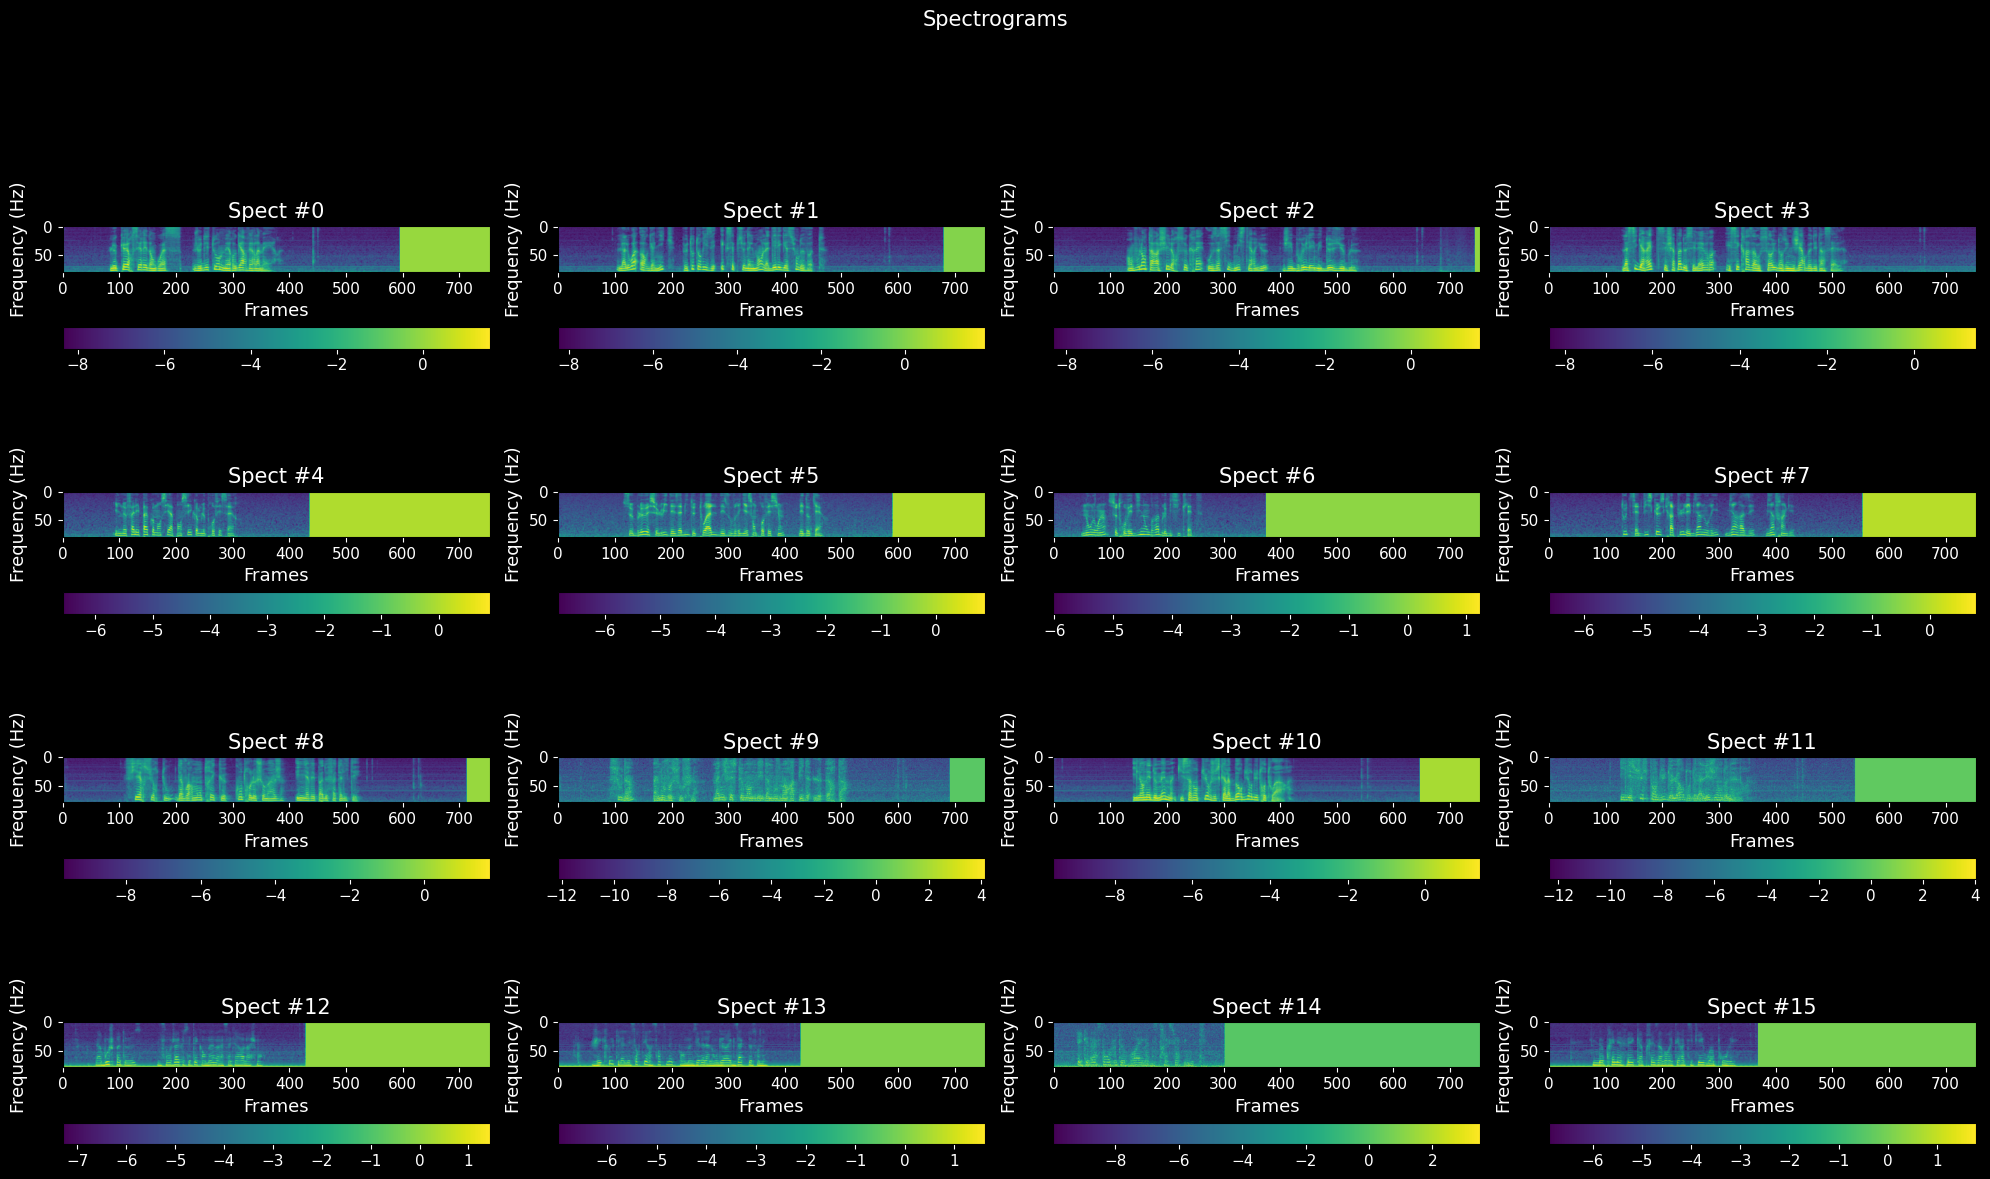

tf.Tensor([ 27  27  27  27 881 881 881 881 736 736 736 736 655 655 655 655], shape=(16,), dtype=int32)


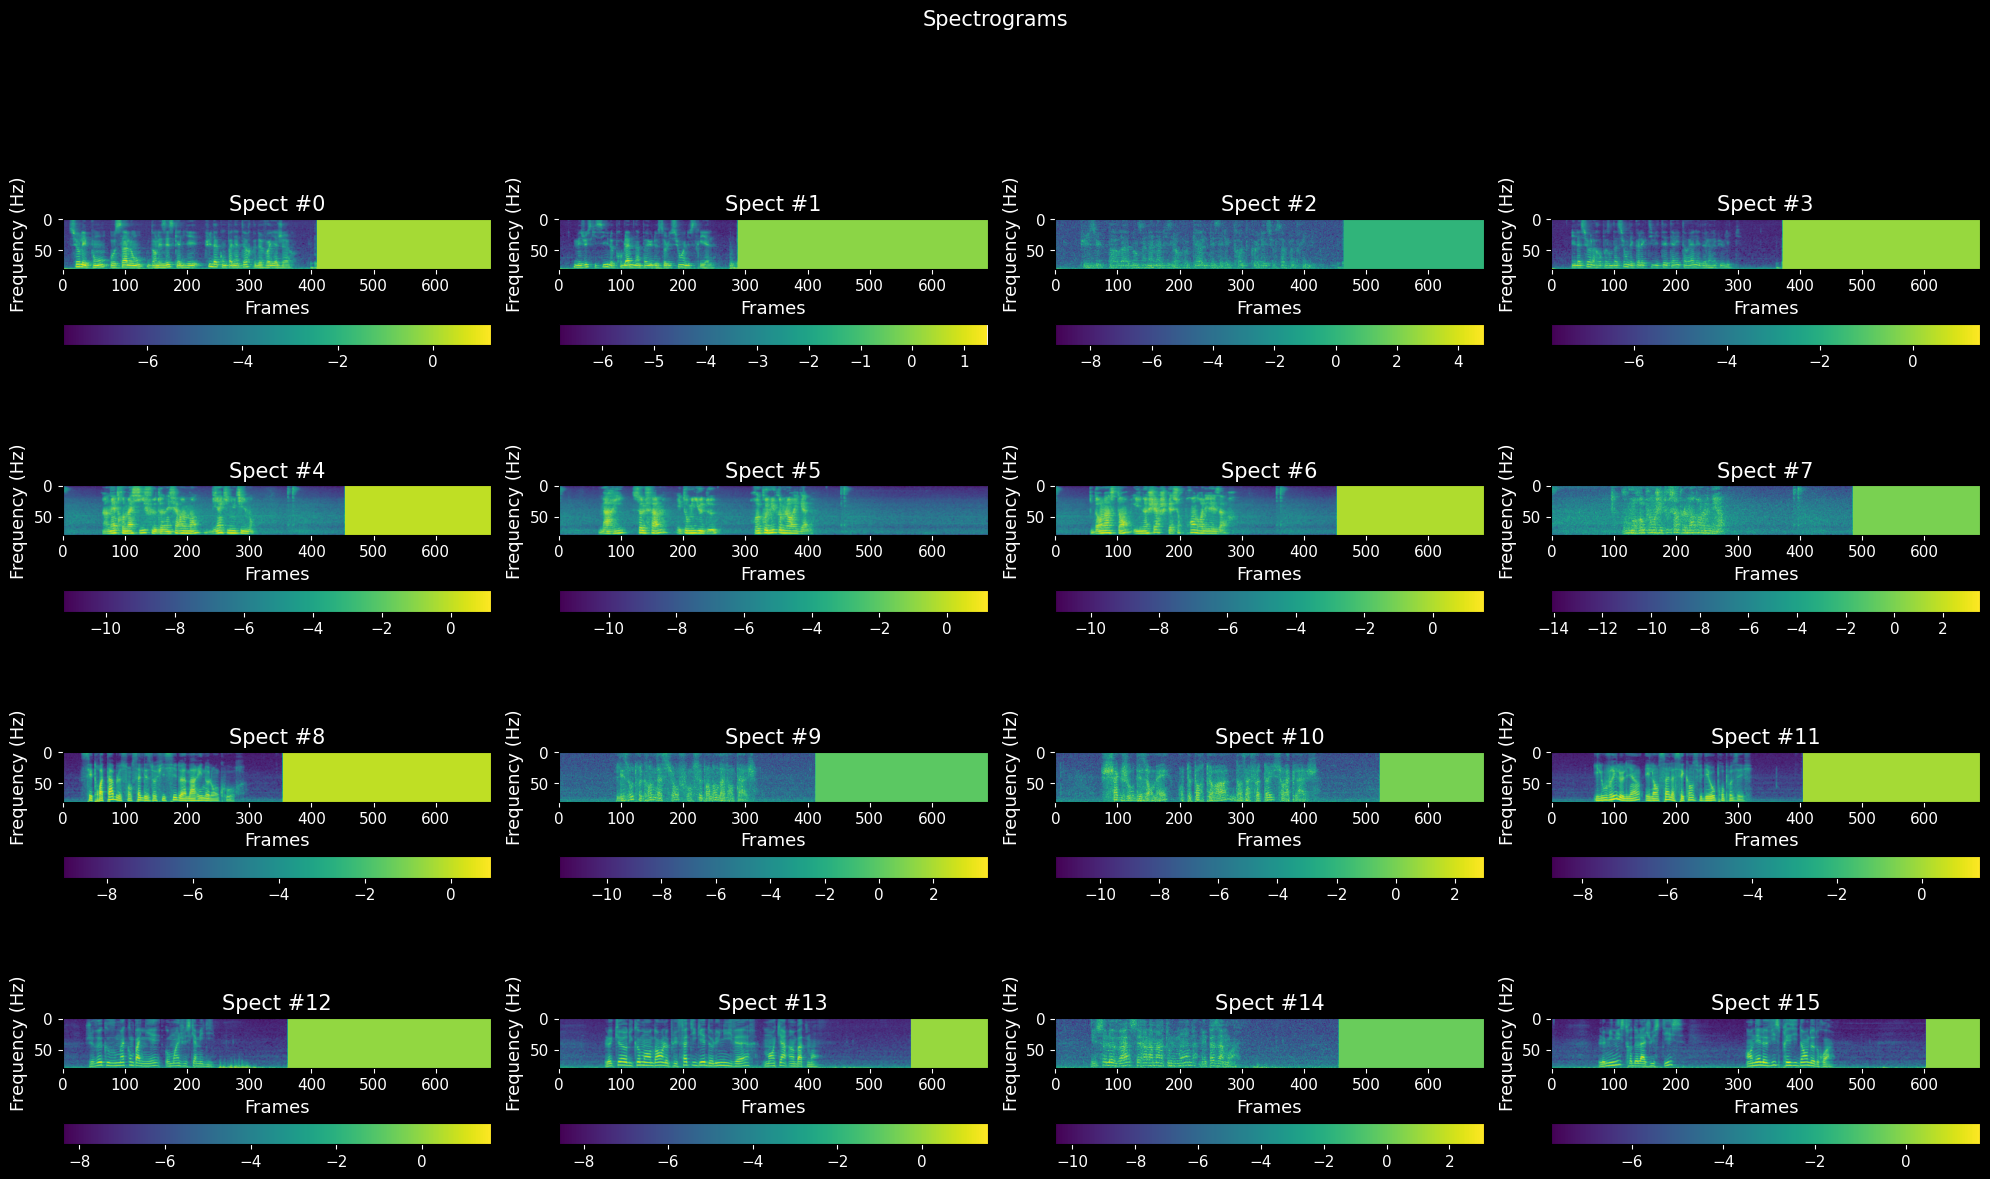

49it [00:02, 20.41it/s]


50 batchs in 2.403 sec sec (20.805 batch / sec)

Batch infos : 
Item 0 : shape : (16, 657, 80) - type : float32- min : -15.406 - max : 4.556
Item 1 : shape : (16,) - type : int32- min : 328.000 - max : 1133.000


2.4033102989196777

In [5]:
from loggers import set_level
from utils import *

test_dataset = get_dataset('voxforge')

set_level('debug', 'datasets')

test_utter = 4

test_gen = AudioGrouperGenerator(
    test_dataset, n_utterance = test_utter, rate = model.audio_rate, mel_fn = model.mel_fn,
    batch_size = test_utter ** 2, n_round = 5, cache_size = 50000, min_occurence = 0, preload = False,
    random_state = 10, shuffle = True
)

print(test_gen)

config = model.get_dataset_config(batch_size = test_gen.batch_size, is_validation = False, shuffle_size = 0, cache = False)
ds     = prepare_dataset(test_gen, ** config)

for inp, out in ds.take(2):
    print(out)
    plot_spectrogram(** {'Spect #{}'.format(i) : inp[i] for i in range(len(inp))}, ncols = test_utter, size = 3)

test_dataset_time(ds, steps = 50)

tf.Tensor(
[ 904  904  904  904 1760 1760 1760 1760 2173 2173 2173 2173  247  247
  247  247], shape=(16,), dtype=int32)


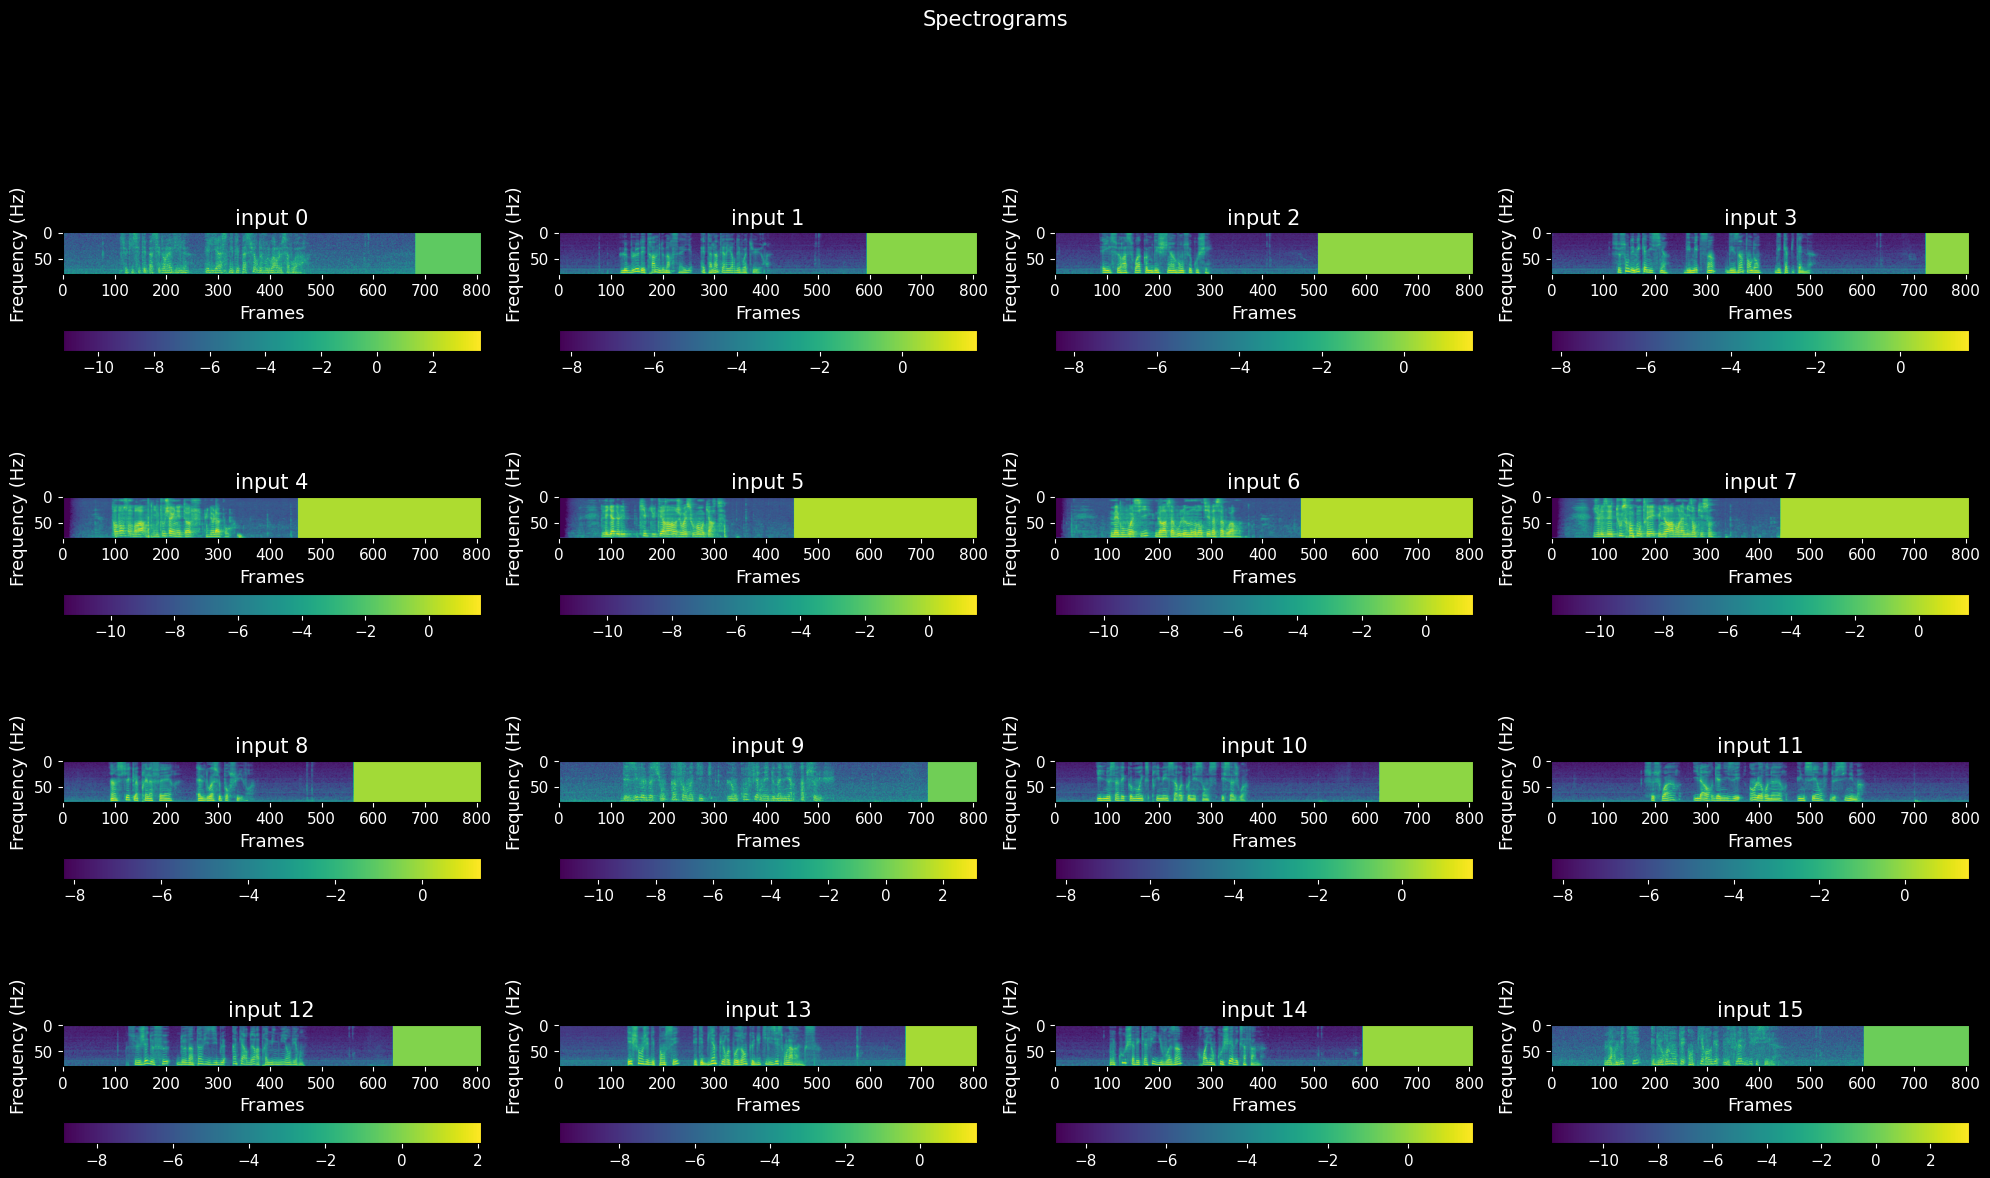

tf.Tensor(
[ 285  285  285  285  758  758  758  758 1165 1165 1165 1165 1191 1191
 1191 1191], shape=(16,), dtype=int32)


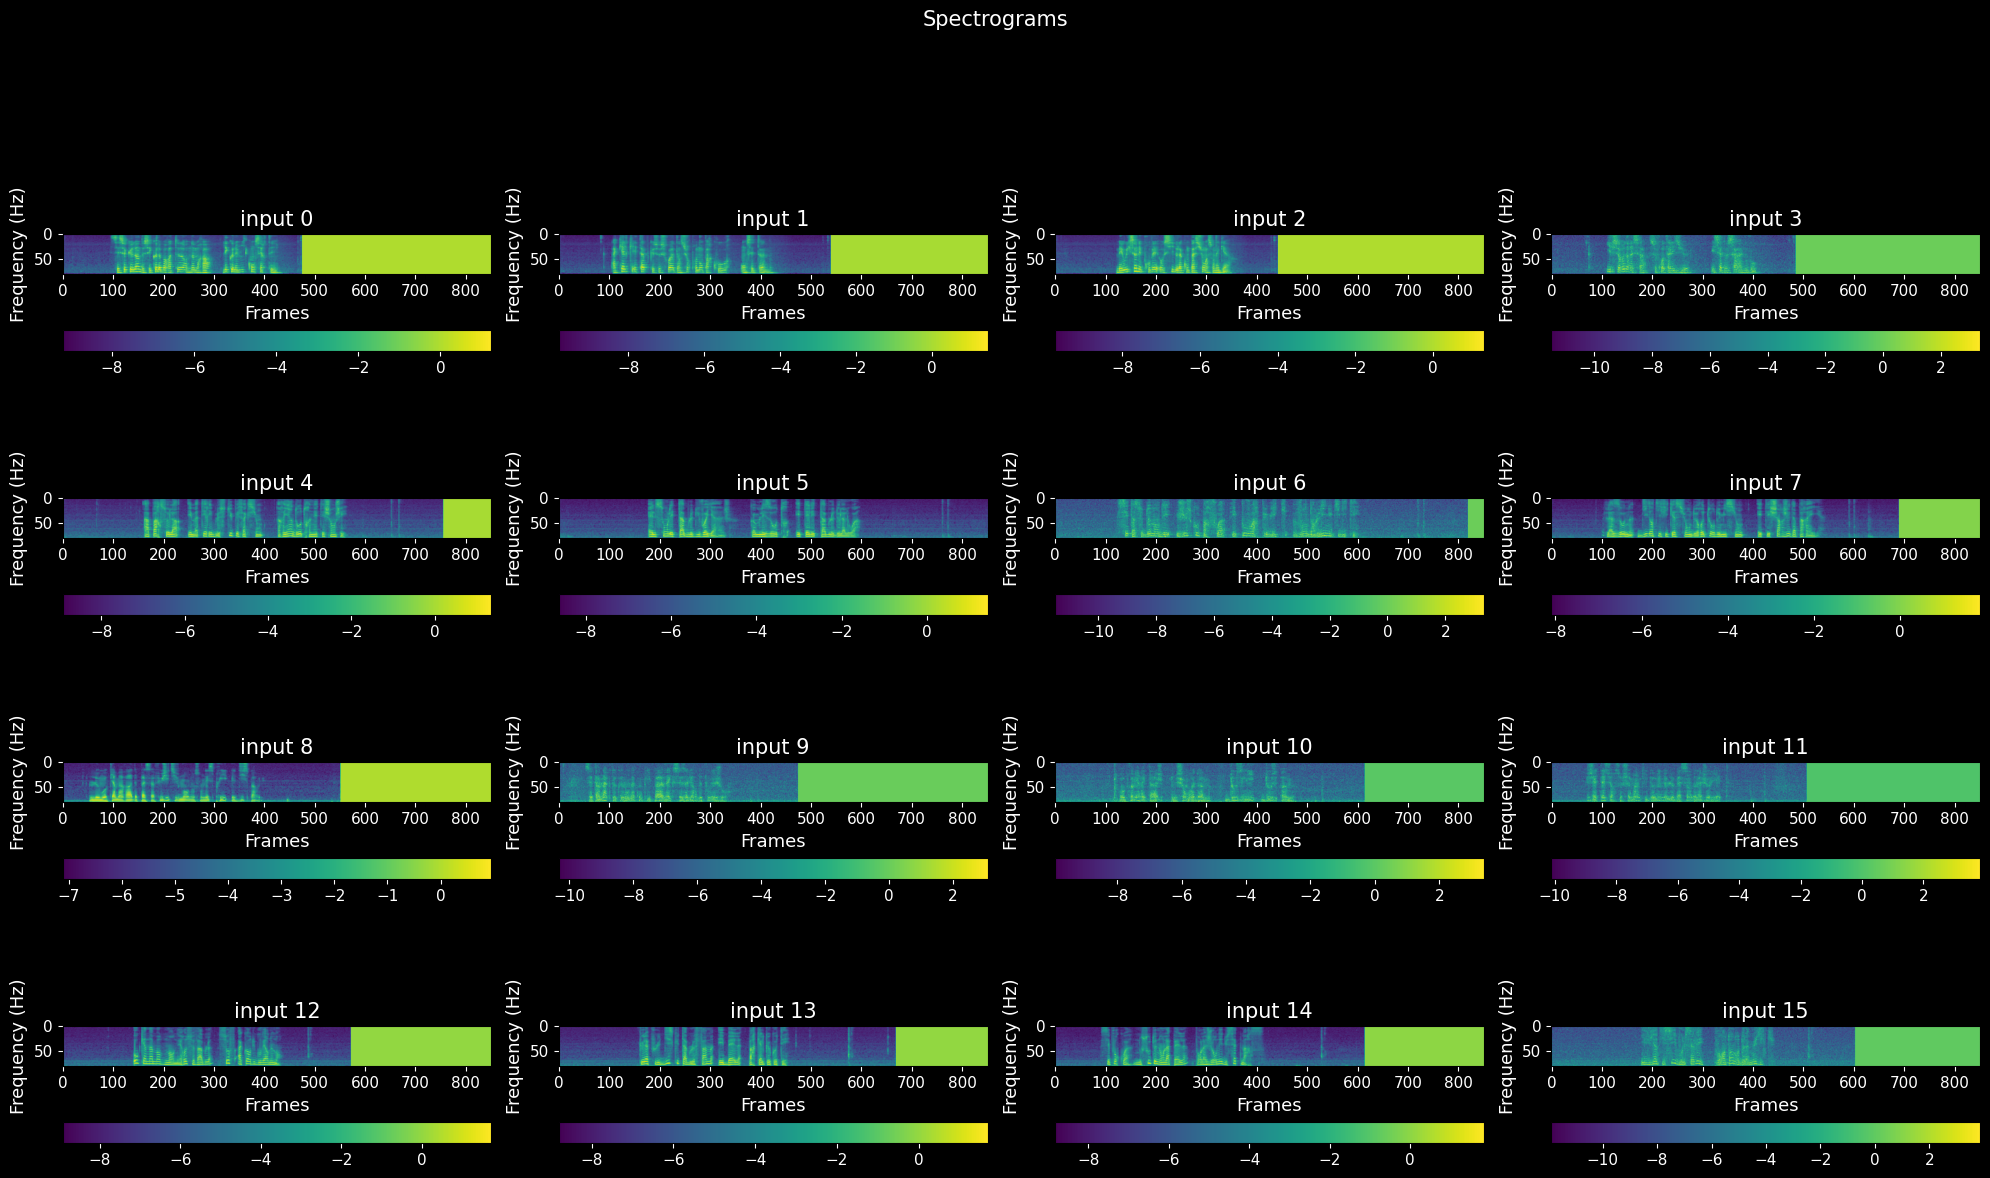

In [6]:
from utils import plot_spectrogram

for inp, out in ds.take(2):
    print(out)
    plot_spectrogram(** {'input {}'.format(i) : inp_i for i, inp_i in enumerate(inp)}, ncols = 4, size = 3)

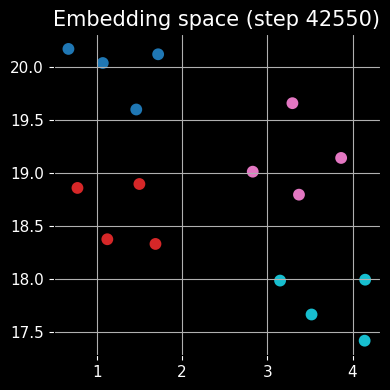

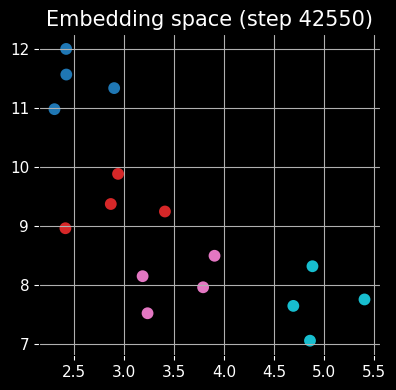

In [8]:
from utils import plot_spectrogram

for batch in ds.take(2):
    model.predict_with_target(batch, show = True, step = model.steps, prefix = 'test')

### Test batching

In [8]:
from utils import is_equal

test_ds = get_dataset('siwis')
samples = test_ds.sample(128, random_state = 0)

emb1 = model.embed(samples, batch_size = 1)
emb2 = model.embed(samples, batch_size = 128)

print(is_equal(emb1, emb2))

Loading dataset siwis...
(False, 'Values differ (6571 / 32768 diff, 0.201%) : max 0.0003789067268371582 - mean 3.947122422687244e-06 - min 9.094947017729282e-13')


### Test learning-rate scheduler

In [ ]:
from custom_train_objects.optimizers import WarmupScheduler

lr = WarmupScheduler(maxval = 1e-3, minval = 1e-4, factor = 256, warmup_steps = 4096)
lr.plot(25000)